# Data Science Project: Analyze COVID-19 vaccination data

Data Source: https://vaers.hhs.gov/data/datasets.html    
Data Guide: https://vaers.hhs.gov/docs/VAERSDataUseGuide_November2020.pdf

* VAERS: Vaccine Adverse Event Reporting System
* dataset created by the Food andd Drug Administration and Centers for Disease Control and Prevention to
receive reports about adverse events that may be associated with vaccines
* data contains only patients with symptoms, so we don't know the overall number of vaccinated people 
* 2 forms (VAERS 1, VAERS 2) existing with slightly different fields (description in guide)
* data is from 2021, latest date: 02/19/2021

## Business Understanding - Questions:

1. What are the most common side effects (symptoms) reported and when do they occur?
2. Severe symptoms - How many patients had to be hospitalized or died?
3. What is the (medical) background of the patients who died?
4. Can we predict the hospitalization of a patient based on the data?

## Data Understanding

* data sets: patients data (df_patients), data about their symptoms (df_symptoms) , data about the vaccines (df_vax)
* we can identify the patients with "VAERS_ID" for all data sets $\rightarrow$ 9286 patients

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score

%matplotlib inline

In [2]:
# read in all datasets
df_patients = pd.read_csv('./data/data_021921/2021VAERSDATA.csv', engine='python')
df_symptoms = pd.read_csv('./data/data_021921/2021VAERSSYMPTOMS.csv')
df_vax = pd.read_csv('./data/data_021921/2021VAERSVAX.csv')

In [3]:
print(df_patients.shape)
print(df_symptoms.shape)
print(df_vax.shape)

(9286, 35)
(14343, 11)
(9442, 8)


In [4]:
print(df_patients.columns)

Index(['VAERS_ID', 'RECVDATE', 'STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX',
       'RPT_DATE', 'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT',
       'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE',
       'ONSET_DATE', 'NUMDAYS', 'LAB_DATA', 'V_ADMINBY', 'V_FUNDBY',
       'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'SPLTTYPE',
       'FORM_VERS', 'TODAYS_DATE', 'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT',
       'ALLERGIES'],
      dtype='object')


In [5]:
print(df_symptoms.columns)

Index(['VAERS_ID', 'SYMPTOM1', 'SYMPTOMVERSION1', 'SYMPTOM2',
       'SYMPTOMVERSION2', 'SYMPTOM3', 'SYMPTOMVERSION3', 'SYMPTOM4',
       'SYMPTOMVERSION4', 'SYMPTOM5', 'SYMPTOMVERSION5'],
      dtype='object')


In [6]:
print(df_vax.columns)

Index(['VAERS_ID', 'VAX_TYPE', 'VAX_MANU', 'VAX_LOT', 'VAX_DOSE_SERIES',
       'VAX_ROUTE', 'VAX_SITE', 'VAX_NAME'],
      dtype='object')


In [7]:
# check if all datasets have the same number of patients
print(df_patients["VAERS_ID"].nunique())
print(df_symptoms["VAERS_ID"].nunique())
print(df_vax["VAERS_ID"].nunique())

9286
9286
9286


In [8]:
df_patients.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,CAGE_MO,SEX,RPT_DATE,SYMPTOM_TEXT,DIED,...,CUR_ILL,HISTORY,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES
0,916600,01/01/2021,TX,33.0,33.0,NaN,F,NaN,Right side of epiglottis swelled up and hinder...,NaN,...,None,None,NaN,NaN,2,01/01/2021,NaN,Y,NaN,Pcn and bee venom
1,916601,01/01/2021,CA,73.0,73.0,NaN,F,NaN,Approximately 30 min post vaccination administ...,NaN,...,Patient residing at nursing facility. See pati...,Patient residing at nursing facility. See pati...,NaN,NaN,2,01/01/2021,NaN,Y,NaN,"""Dairy"""
2,916602,01/01/2021,WA,23.0,23.0,NaN,F,NaN,"About 15 minutes after receiving the vaccine, ...",NaN,...,None,None,NaN,NaN,2,01/01/2021,NaN,NaN,Y,Shellfish
3,916603,01/01/2021,WA,58.0,58.0,NaN,F,NaN,"extreme fatigue, dizziness,. could not lift my...",NaN,...,kidney infection,"diverticulitis, mitral valve prolapse, osteoar...","got measles from measel shot, mums from mumps ...",NaN,2,01/01/2021,NaN,NaN,NaN,"Diclofenac, novacaine, lidocaine, pickles, tom..."
4,916604,01/01/2021,TX,47.0,47.0,NaN,F,NaN,"Injection site swelling, redness, warm to the ...",NaN,...,Na,NaN,NaN,NaN,2,01/01/2021,NaN,NaN,NaN,Na


In [9]:
# Look at datatypes
df_patients.dtypes

VAERS_ID          int64
RECVDATE         object
STATE            object
AGE_YRS         float64
CAGE_YR         float64
CAGE_MO         float64
SEX              object
RPT_DATE         object
SYMPTOM_TEXT     object
DIED             object
DATEDIED         object
L_THREAT         object
ER_VISIT         object
HOSPITAL         object
HOSPDAYS        float64
X_STAY           object
DISABLE          object
RECOVD           object
VAX_DATE         object
ONSET_DATE       object
NUMDAYS         float64
LAB_DATA         object
V_ADMINBY        object
V_FUNDBY         object
OTHER_MEDS       object
CUR_ILL          object
HISTORY          object
PRIOR_VAX        object
SPLTTYPE         object
FORM_VERS         int64
TODAYS_DATE      object
BIRTH_DEFECT     object
OFC_VISIT        object
ER_ED_VISIT      object
ALLERGIES        object
dtype: object

In [10]:
df_symptoms.head()

,VAERS_ID,SYMPTOM1,SYMPTOMVERSION1,SYMPTOM2,SYMPTOMVERSION2,SYMPTOM3,SYMPTOMVERSION3,SYMPTOM4,SYMPTOMVERSION4,SYMPTOM5,SYMPTOMVERSION5
0,916600,Dysphagia,23.1,Epiglottitis,23.1,NaN,NaN,NaN,NaN,NaN,NaN
1,916601,Anxiety,23.1,Dyspnoea,23.1,NaN,NaN,NaN,NaN,NaN,NaN
2,916602,Chest discomfort,23.1,Dysphagia,23.1,Pain in extremity,23.1,Visual impairment,23.1,NaN,NaN
3,916603,Dizziness,23.1,Fatigue,23.1,Mobility decreased,23.1,NaN,NaN,NaN,NaN
4,916604,Injection site erythema,23.1,Injection site pruritus,23.1,Injection site swelling,23.1,Injection site warmth,23.1,NaN,NaN


In [11]:
df_vax.head()

,VAERS_ID,VAX_TYPE,VAX_MANU,VAX_LOT,VAX_DOSE_SERIES,VAX_ROUTE,VAX_SITE,VAX_NAME
0,916600,COVID19,MODERNA,037K20A,1,IM,LA,COVID19 (COVID19 (MODERNA))
1,916601,COVID19,MODERNA,025L20A,1,IM,RA,COVID19 (COVID19 (MODERNA))
2,916602,COVID19,PFIZER\BIONTECH,EL1284,1,IM,LA,COVID19 (COVID19 (PFIZER-BIONTECH))
3,916603,COVID19,MODERNA,unknown,UNK,NaN,NaN,COVID19 (COVID19 (MODERNA))
4,916604,COVID19,MODERNA,NaN,1,IM,LA,COVID19 (COVID19 (MODERNA))


## Data Preparation / Cleaning

### General Data Cleaning

In [12]:
def cols_all_nan(df):
    ''' Returns columns with NaN for every row in df
    
    INPUT:
    df - pandas dataframe
    
    OUTPUT:
    list of column indices for all columns with all NaN values 
    '''
    return df.columns[df.isnull().all()]

In [13]:
def cols_with_nan(df, percentage):
    '''Returns the column names that have more than (percentage * 100) %
    of their values missing
    
    INPUT:
    df - pandas dataframe
    percentage - float, percentage of values missing

    OUTPUT:
    list of column indices for all columns where more than (percentage * 100) %
    of their values are missing
    '''
    return df.columns[np.sum(df.isnull())/df.shape[0] > percentage]

In [14]:
print("Cols NaN for all rows: ", cols_all_nan(df_patients)) 
print("Cols NaN for all rows: ", cols_all_nan(df_symptoms))
print("Cols NaN for all rows: ", cols_all_nan(df_vax))

Cols NaN for all rows:  Index([], dtype='object')
Cols NaN for all rows:  Index([], dtype='object')
Cols NaN for all rows:  Index([], dtype='object')


In [15]:
print(cols_with_nan(df_patients, 0.5))
print(cols_with_nan(df_symptoms, 0.5))
print(cols_with_nan(df_vax, 0.5))

Index(['CAGE_MO', 'RPT_DATE', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT',
       'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'DISABLE', 'V_FUNDBY', 'PRIOR_VAX',
       'SPLTTYPE', 'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT'],
      dtype='object')
Index(['SYMPTOM5', 'SYMPTOMVERSION5'], dtype='object')
Index([], dtype='object')


#### Missing Values

There are no columns where all values are NaN. However, for some of the comlumns in df_patients, 50 % or more of the values are missing. For df_symptoms, this is not critical since I will transform the dataframe later anyway.  

**Strategies for handling missing values:**
* general strategy: drop as few columns as possible
* for the columns that have only very few entries due to being from form 1 which is barely used in our dataset, I can drop the columns 
* irrelevant column: e.g. age in months which is only calculated for babies (very few entries with babies) $\rightarrow$ for babies, the age in years (0) is enough
* if the columns are described in the data use guide as "Y" if it applies or NaN otherwise, columns can be transformed into binary columns which can be handled better
* categorical columns (textual data): There is no easy way to handle missing values with textual data (replacing with 0 wouldn't make any sense). For the descriptive statistical analysis (Questions 1 - 3), I'll leave it as it is because the pandas methods ignore NaN values (e.g. when counting values) and I might not need all of these columns. For the prediction task (Question 4), I'll create dummy variables for the categorical variables and use the mean for missing values in numerical columns (see the "clean_data" method below in the section of Question 4).

### Drop columns from Form 1 / Irrelevant Columns

In [16]:
# column "ER_VISIT" is NaN for all entries except 4, for form 2 replaced by "ER_ED_VISIT" -> can be dropped (only few entries with form 1)
df_patients.drop(columns="ER_VISIT", inplace=True)

# cage_mo: calculated age of patient in months -> only available for babies <= 2.0 years (= 8 patients, 0.2% of data) 
# -> decision: age in years is enough for now 
df_patients.drop(columns="CAGE_MO", inplace=True)

# column "RPT_Date" only available for 7 patients (= date form was completed), discontinued for form 2 -> can be dropped
df_patients.drop(columns="RPT_DATE", inplace=True)

# column "V_FUNDBY" is VAERS1 only field, (= funds used to purchase the vaccines) -> not relevant to us, can be dropped
df_patients.drop(columns="V_FUNDBY", inplace=True)

### Transform to Binary columns

In [17]:
# for all columns in y_col, the values are either "Y" or NaN otherwise -> replace by 1 and 0
y_cols = ["ER_ED_VISIT", "DIED", "L_THREAT", "HOSPITAL", "X_STAY", "DISABLE", "BIRTH_DEFECT", "OFC_VISIT"]

for col in y_cols:
    df_patients[col] = np.where(df_patients[col] == "Y", 1, 0)

In [18]:
print("Remaining cols with NaNs are the following: ")
print(cols_with_nan(df_patients, 0.5).values)
print("They are filled with text descriptions or dates, so there is no easy way to replace NaNs but they could be relevant, so for now I will try to work around.")

Remaining cols with NaNs are the following: 
['DATEDIED' 'HOSPDAYS' 'PRIOR_VAX' 'SPLTTYPE']
They are filled with text descriptions or dates, so there is no easy way to replace NaNs but they could be relevant, so for now I will try to work around.


### Replace values that actually mean "NaN" (differs slightly for the respective columns) 

In [19]:
# for the column "CUR_ILL", some of the entries are "None" or "No" (as string) -> change to NaN
df_patients["CUR_ILL"].replace(
    ["None", "No", "NONE", "unknown", "Unknown", "none", "no", "None known", "none known", 
     "None reported", "none reported", "UNKNOWN", "N/a", "None stated/Denied",
    "No other illness prior to vaccination or within the month prior", "NKDA", 
     "Individual was healthy prior to vaccination.", "None.", "UNK", "As noted above", "unsure", 
     "See item 12", "no acute illnesses", "No symptoms after COVID vaccinations"], 
    np.nan, inplace=True)
df_patients["CUR_ILL"].replace("Covid 19", "COVID_19", inplace=True)

In [20]:
# for the column "ALLERGIES", some of the entries are "None" or "No" (as string) -> change to NaN
df_patients["ALLERGIES"].replace(
    ["None", "none", "NKDA", "NKA", "No known allergies", "unknown", 
     "No", "Unknown", "no", "NONE", "No Known Allergies", "no known allergies",
    "nka", "None known", "NKA to medications", "No known allergies to drugs or food"], np.nan, inplace=True)

In [21]:
# for the column "HISTORY", some of the entries are "None" or "No" (as string) -> change to NaN
df_patients["HISTORY"].replace(["None", "none", "unknown", "unsure", "Unknown", "no", 
                                "Unsure", "No", "NONE", "UNKNOWN", "N/a", "None known",
                               "None reported", "none reported", "None stated/Denied", 
                                "none known", "Medical History/Concurrent Conditions: No adverse event (No reported medical history.)",
                                "Medical History/Concurrent Conditions: No adverse event (No reported medical history)", "None disclosed"
                               ], np.nan, inplace=True)

In [22]:
# for the column "OTHER MEDS", some of the entries are "None" or "No" (as string) -> change to NaN
df_patients["OTHER_MEDS"].replace(["None", "none", "unknown", "Unknown", "no", "NONE", "UNKNOWN", "No"]
                                 , np.nan, inplace=True)

In [23]:
# Replacing NaN value with 0 makes sense for counting of days being hospitalized
df_patients["HOSPDAYS"].replace(np.nan, 0, inplace=True)

#### Explanation for Symptoms Text in Patients Dataset
Reported Symptom Text (SYMPTOM_TEXT): This is the symptom text
recorded in the form (in df_patients). MedDRA Terms are derived from this text and placed in the
VAERSSYMPTOMS file.
$\rightarrow$ "SYMPTOM_TEXT" can be ignored, order of terms in df_symptoms are not relevant

In [24]:
# Transform the symptoms dataset so that there is only one column for the symptoms
df_symptoms_m = pd.melt(df_symptoms, id_vars=['VAERS_ID'], value_vars=['SYMPTOM1', 'SYMPTOM2', 
                                                                'SYMPTOM3', 'SYMPTOM4', 'SYMPTOM5'],
                     var_name='NUMBER', value_name='SYMPTOM')
df_symptoms_m.dropna(subset=['SYMPTOM'], inplace=True)


df_symptoms_m.head()

,VAERS_ID,NUMBER,SYMPTOM
0,916600,SYMPTOM1,Dysphagia
1,916601,SYMPTOM1,Anxiety
2,916602,SYMPTOM1,Chest discomfort
3,916603,SYMPTOM1,Dizziness
4,916604,SYMPTOM1,Injection site erythema


In [25]:
# exclude symptoms that are no symptoms (found during analysis)
no_symptoms = ["SARS-CoV-2 test negative", "Computerised tomogram", "Exposure to SARS-CoV-2",
              "Laboratory test", "Electrocardiogram", "Blood test", "Chest X-ray", 
               "Magnetic resonance imaging", "Full blood count"]
df_symptoms_m = df_symptoms_m[~df_symptoms_m["SYMPTOM"].isin(no_symptoms)]

In [26]:
print(df_patients.shape)
print(df_symptoms_m.shape)
print(df_vax.shape)

(9286, 31)
(48205, 3)
(9442, 8)


**Observation:**  
While for the patients dataset there is only one entry per person (9286 patients in total), it can be more than one entry (row) for the other datasets (> 1 symptom for one patient, > 1 vaccination per person).  
I'm only interested in the COVID19 vaccinations, so I will drop the others. Since there are only 120 other vaccination entries, a comparison wouldn't work well anyway.

In [27]:
covid_ids = df_vax[df_vax["VAX_TYPE"] == "COVID19"]["VAERS_ID"].unique().tolist()
print("# Patients with covid vaccination: ", len(covid_ids))
covid_patients = df_patients[df_patients["VAERS_ID"].isin(covid_ids)]
print("# Patients of reduced patients dataset: ", covid_patients["VAERS_ID"].shape)
covid_symptoms = df_symptoms_m[df_symptoms_m["VAERS_ID"].isin(covid_ids)]
print("# Patients of reduced symptoms dataset: ", covid_symptoms["VAERS_ID"].shape)
covid_vax = df_vax[df_vax["VAERS_ID"].isin(covid_ids)]
print("# Patients of reduced vax dataset: ", covid_vax["VAERS_ID"].shape)

# Patients with covid vaccination:  9100
# Patients of reduced patients dataset:  (9100,)
# Patients of reduced symptoms dataset:  (47224,)
# Patients of reduced vax dataset:  (9208,)


#### Create Dataset Combinations

In [28]:
patient_symp = covid_patients.merge(covid_symptoms, on="VAERS_ID")
patient_symp.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,SEX,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,...,PRIOR_VAX,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES,NUMBER,SYMPTOM
0,916600,01/01/2021,TX,33.0,33.0,F,Right side of epiglottis swelled up and hinder...,0,NaN,0,...,NaN,NaN,2,01/01/2021,0,1,0,Pcn and bee venom,SYMPTOM1,Dysphagia
1,916600,01/01/2021,TX,33.0,33.0,F,Right side of epiglottis swelled up and hinder...,0,NaN,0,...,NaN,NaN,2,01/01/2021,0,1,0,Pcn and bee venom,SYMPTOM2,Epiglottitis
2,916601,01/01/2021,CA,73.0,73.0,F,Approximately 30 min post vaccination administ...,0,NaN,0,...,NaN,NaN,2,01/01/2021,0,1,0,"""Dairy""",SYMPTOM1,Anxiety
3,916601,01/01/2021,CA,73.0,73.0,F,Approximately 30 min post vaccination administ...,0,NaN,0,...,NaN,NaN,2,01/01/2021,0,1,0,"""Dairy""",SYMPTOM2,Dyspnoea
4,916602,01/01/2021,WA,23.0,23.0,F,"About 15 minutes after receiving the vaccine, ...",0,NaN,0,...,NaN,NaN,2,01/01/2021,0,0,1,Shellfish,SYMPTOM1,Chest discomfort


In [29]:
pt_symp_vax = patient_symp.merge(covid_vax[["VAERS_ID", "VAX_MANU"]], on="VAERS_ID")
pt_symp_vax.head()

,VAERS_ID,RECVDATE,STATE,AGE_YRS,CAGE_YR,SEX,SYMPTOM_TEXT,DIED,DATEDIED,L_THREAT,...,SPLTTYPE,FORM_VERS,TODAYS_DATE,BIRTH_DEFECT,OFC_VISIT,ER_ED_VISIT,ALLERGIES,NUMBER,SYMPTOM,VAX_MANU
0,916600,01/01/2021,TX,33.0,33.0,F,Right side of epiglottis swelled up and hinder...,0,NaN,0,...,NaN,2,01/01/2021,0,1,0,Pcn and bee venom,SYMPTOM1,Dysphagia,MODERNA
1,916600,01/01/2021,TX,33.0,33.0,F,Right side of epiglottis swelled up and hinder...,0,NaN,0,...,NaN,2,01/01/2021,0,1,0,Pcn and bee venom,SYMPTOM2,Epiglottitis,MODERNA
2,916601,01/01/2021,CA,73.0,73.0,F,Approximately 30 min post vaccination administ...,0,NaN,0,...,NaN,2,01/01/2021,0,1,0,"""Dairy""",SYMPTOM1,Anxiety,MODERNA
3,916601,01/01/2021,CA,73.0,73.0,F,Approximately 30 min post vaccination administ...,0,NaN,0,...,NaN,2,01/01/2021,0,1,0,"""Dairy""",SYMPTOM2,Dyspnoea,MODERNA
4,916602,01/01/2021,WA,23.0,23.0,F,"About 15 minutes after receiving the vaccine, ...",0,NaN,0,...,NaN,2,01/01/2021,0,0,1,Shellfish,SYMPTOM1,Chest discomfort,PFIZER\BIONTECH


## Modeling Data

In [30]:
def plot_pie(labels, sizes, explode, save_title=None):
    '''Plot pie chart
    
    INPUT:
    labels - labels for wedges
    sizes - wedge sizes
    explode - specifies the fraction of the radius with which to offset each wedge
    save_title - name to save as png
    '''
    fig1, ax1 = plt.subplots()
    
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    if save_title != None:
        path = "plots/" + save_title
        plt.savefig(path, bbox_inches = "tight")

    plt.show() 

In [31]:
def bar_plot(values, title, save_title=None):
    ''' Plot bar plot
    
    INPUT:
    values - content to plot as pandas series
    title - plot title
    save_title - name to save as png
    '''
    ax = values.plot(kind='bar')
    t = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.set_title(title)
    if save_title != None:
        path = "plots/" + save_title
        plt.savefig(path, bbox_inches = "tight")
    
    plt.show()

In [32]:
# relevant values / modifications
all_patients = covid_patients["VAERS_ID"].nunique()

pos = "SARS-CoV-2 test positive"
cov_pos_id = covid_symptoms[covid_symptoms["SYMPTOM"] == pos]["VAERS_ID"].unique()

# all patients not tested positive for Covid (excluded starting from Q 1.1)
all_patients_nc = covid_patients[~covid_patients["VAERS_ID"].isin(cov_pos_id)]["VAERS_ID"].nunique()

### Overview Vaccination Manufacturers

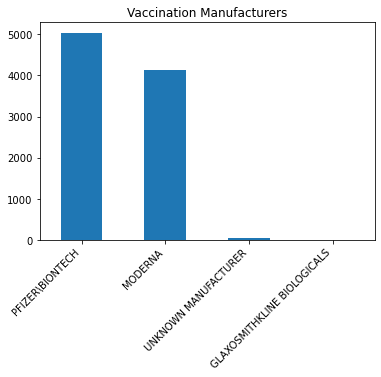

In [33]:
bar_plot(covid_vax["VAX_MANU"].value_counts(), "Vaccination Manufacturers", "manufacturer.png")

In [34]:
pfizer = covid_vax[covid_vax["VAX_MANU"] == "PFIZER\BIONTECH"].shape[0]
moderna = covid_vax[covid_vax["VAX_MANU"] == "MODERNA"].shape[0]
print("{:.1f} % of the vaccinations are from PFIZER/BIONTECH, {:.1f} % are from MODERNA.".format(
(pfizer/all_patients * 100), (moderna/all_patients * 100)))

55.4 % of the vaccinations are from PFIZER/BIONTECH, 45.5 % are from MODERNA.


### Overview Data from States

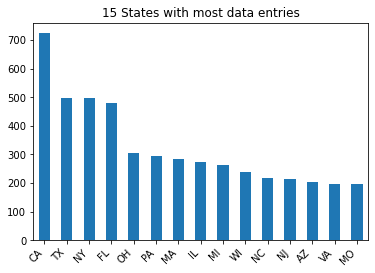

In [35]:
bar_plot(covid_patients["STATE"].value_counts()[:15], "15 States with most data entries")

### Overview Age of the Patients

In [36]:
covid_patients["AGE_YRS"].describe()

count    8058.000000
mean       53.406654
std        19.642475
min         0.250000
25%        37.000000
50%        51.000000
75%        68.000000
max       105.000000
Name: AGE_YRS, dtype: float64

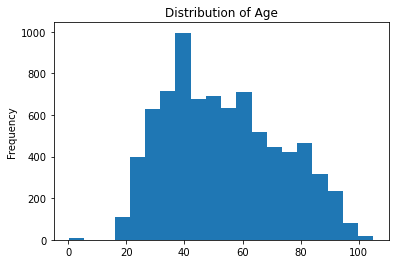

In [37]:
ax = covid_patients["AGE_YRS"].plot(kind='hist', bins=20)
ax.set_title("Distribution of Age")
plt.savefig("plots/age_all.png")
plt.show()

The side effects seem to occur most often for patients roughly between 40 and 60.

## Overview Sex

In [38]:
sex = covid_patients["SEX"].value_counts()
ratio_f = sex["F"] / all_patients * 100
ratio_m = sex["M"] / all_patients * 100
ratio_u = sex["U"] / all_patients * 100
ratio_f
print("Ratio Female: {:.1f} %, Ratio Male: {:.1f} %, Ratio Unkown: {:.1f} %".format(ratio_f, ratio_m, ratio_u))

Ratio Female: 68.0 %, Ratio Male: 28.4 %, Ratio Unkown: 3.6 %


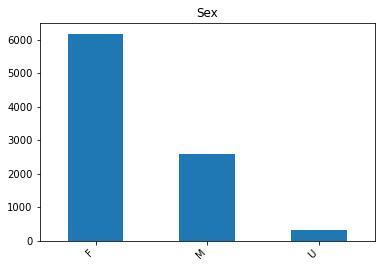

In [39]:
bar_plot(sex, "Sex", "sex.png")

## Question 1: What are the most common side effects (symptoms)?

#### Description of Symptoms Dataset
The fields described in this table provide the adverse event coded terms utilizing the
MedDRA dictionary. Coders will search for specific terms in Items 18 and 19 in
VAERS 2 form or Boxes 7 and 12 on the VAERS 1 form and code them to a
searchable and consistent MedDRA term; note that terms are included in the .csv file
in alphabetical order. There can be an unlimited amount of coded terms for a given
event. Each row in the .csv will contain up to 5 MedDRA terms per VAERS ID; thus,
there could be multiple rows per VAERS ID. For each of the VAERS_ID’s listed in the
VAERSDATA.CSV table, there is a matching record in this file, identified by
VAERS_ID.

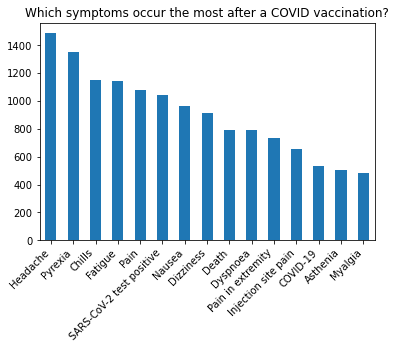

In [40]:
# Out of all symptoms, which ones occur the most?
symptom_values = covid_symptoms["SYMPTOM"].value_counts()
bar_plot(symptom_values[:15], "Which symptoms occur the most after a COVID vaccination?", "common_symptoms.png")

**Observations:**

* mostly lighter symptoms
* noticable: SARS-CoV-2 test positive, death

**Note:** From now on, I will exclude patients with positive Covid test since we cannot determine whether their symptoms might be associated with their infection or the vaccination.

### Question 1.1: What are the most common symptoms for patients without positive Covid test? 

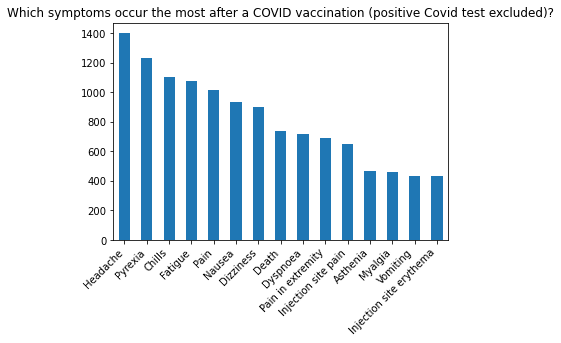

In [41]:
no_covid_symptoms = covid_symptoms[(~covid_symptoms["VAERS_ID"].isin(cov_pos_id))]
no_covid_values = no_covid_symptoms["SYMPTOM"].value_counts()

bar_plot(no_covid_values[:15], "Which symptoms occur the most after a COVID vaccination (positive Covid test excluded)?")

In [42]:
# display differences between symptoms with Covid patients vs. without Covid patients
diff = pd.Series(symptom_values[:15].subtract(no_covid_values[:13], fill_value=0), name='DIFFERENCE') #, index=symptom_values[:15].index)
diff_red = diff.drop(labels=['COVID-19', pos])

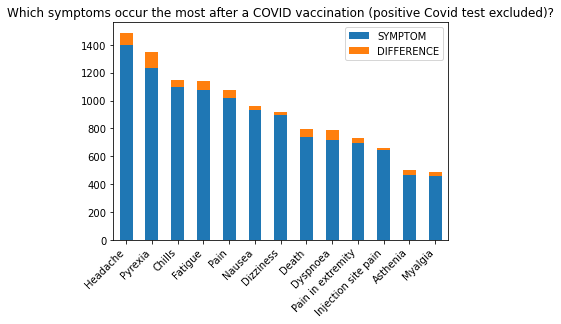

In [43]:
diff_symptoms = pd.concat([no_covid_values[:13], diff_red], axis=1)
ax = diff_symptoms.plot(kind='bar', stacked=True)
t = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title("Which symptoms occur the most after a COVID vaccination (positive Covid test excluded)?")
path = "plots/" + "common_symptoms_no_covid.png"
plt.savefig(path, bbox_inches = "tight")

plt.show()

### Question 1.2: When do these symptoms occur on average? 

In [44]:
covid_patients["NUMDAYS"].describe()

count     8242.000000
mean        20.267532
std        594.243915
min          0.000000
25%          0.000000
50%          1.000000
75%          4.000000
max      36896.000000
Name: NUMDAYS, dtype: float64

In [45]:
# Observation: some of the VAX_DATE entries are not correct, probably incorrect year
# Exclude for this visualization but data entries could still be ok for other questions
covid_patients[covid_patients["NUMDAYS"] > 40][["ONSET_DATE", "VAX_DATE", "RECVDATE"]].head(10)

,ONSET_DATE,VAX_DATE,RECVDATE
287,12/29/2020,07/10/1992,01/01/2021
359,12/27/2020,09/13/1959,01/01/2021
395,12/28/2020,12/23/2019,01/01/2021
895,12/31/2020,10/31/2020,01/02/2021
972,01/02/2021,01/02/2020,01/03/2021
1245,01/02/2021,01/02/2020,01/03/2021
1264,12/28/2020,10/04/1986,01/03/2021
1627,01/01/2021,01/04/2020,01/04/2021
1657,01/04/2021,01/02/2020,01/04/2021
1819,01/03/2021,12/27/2000,01/04/2021


In [46]:
clean_part = covid_patients[covid_patients["NUMDAYS"] < 40]
clean_part["NUMDAYS"].describe()

count    8211.000000
mean        3.096091
std         5.170482
min         0.000000
25%         0.000000
50%         1.000000
75%         4.000000
max        39.000000
Name: NUMDAYS, dtype: float64

**Observation:** On average, the symptoms occur after ca. 3 days.

## Question 2: How many patients were hospitalized or died? 

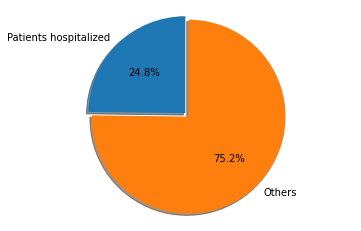

1998  patients were hospitalized.


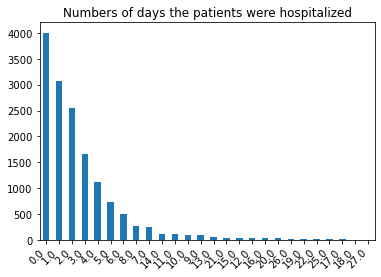

In [47]:
# Severeness of symptoms: How many patients were hospitalized?
hospitalized = patient_symp[(patient_symp["HOSPITAL"] == 1) & (~patient_symp["VAERS_ID"].isin(cov_pos_id))]
count_hospitalized = hospitalized["VAERS_ID"].nunique()

labels = 'Patients hospitalized', 'Others'
sizes = [count_hospitalized, (all_patients_nc-count_hospitalized)]
explode = (0.05, 0)
plot_pie(labels, sizes, explode)

print(count_hospitalized, " patients were hospitalized.")
bar_plot(hospitalized["HOSPDAYS"].value_counts(), "Numbers of days the patients were hospitalized")

Since a major proportion of the hospitalized patients stayed for 0 days, we can additionally look at ratio for hospitalized patients who stayed minimum 1 day. These should be more interesting for us.

1334 stayed in a hospital for >= 1 day.


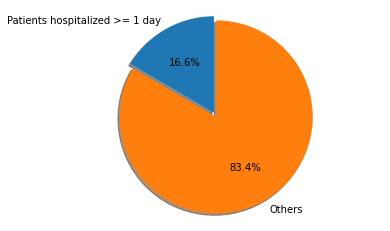

In [48]:
longer_hospitalized = hospitalized[hospitalized["HOSPDAYS"] > 0]
count_lhospitalized = longer_hospitalized["VAERS_ID"].nunique()
print(count_lhospitalized, "stayed in a hospital for >= 1 day.")

labels = 'Patients hospitalized >= 1 day', 'Others'
sizes = [count_lhospitalized, (all_patients_nc-count_lhospitalized)]
explode = (0.05, 0)
plot_pie(labels, sizes, explode, "hospitalized_pie.png") # percent

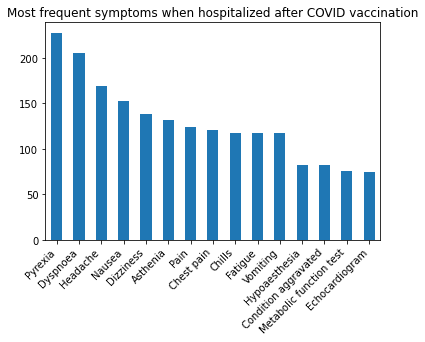

In [49]:
bar_plot(longer_hospitalized["SYMPTOM"].value_counts()[:15], 
         "Most frequent symptoms when hospitalized after COVID vaccination",
        "hospitalized_symptoms.png")

873 patients died after vaccination.


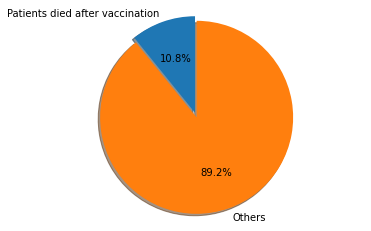

In [50]:
died = patient_symp[(patient_symp["DIED"] == 1) &  (~patient_symp["VAERS_ID"].isin(cov_pos_id))]
persons_died = died["VAERS_ID"].nunique()
print(persons_died, "patients died after vaccination.")
death_ratio = persons_died / all_patients_nc

labels = 'Patients died after vaccination', 'Others'
sizes = [persons_died, (all_patients_nc-persons_died)]
explode = (0.05, 0)

plot_pie(labels, sizes, explode, "died_pie.png") 

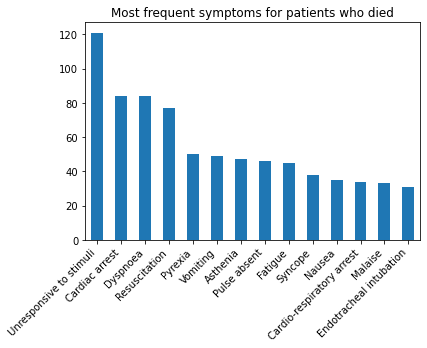

In [51]:
# excluding symptom 0 (which would be "death")
bar_plot(died["SYMPTOM"].value_counts()[1:15], "Most frequent symptoms for patients who died",
        "died_symptoms.png")

## Qestion 3: What is the (medical) background of the patients who died?

Of all patients who died,  69.07% (603 patients) had a history of illness at the time of vaccination.
Of all patients who died,  41.81% (365 patients) were ill at the time of vaccination.


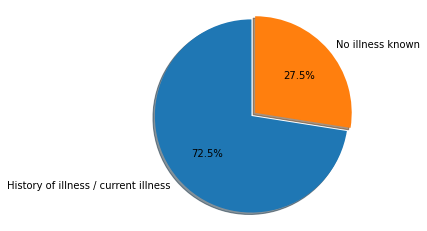

In [52]:
history = died[died["HISTORY"].notnull()]["VAERS_ID"]
illness = died[died["CUR_ILL"].notnull()]["VAERS_ID"]
history_nr = history.nunique()
illness_nr = illness.nunique()

history_illness = pd.concat([history, illness], ignore_index=True, sort=False)
history_illness_nr = history_illness.nunique()


ratio_history_death = history_nr / persons_died * 100
print("Of all patients who died, ", 
      "{:.2f}% ({} patients) had a history of illness at the time of vaccination.".format(ratio_history_death, history_nr)) 

ratio_illness_death = illness_nr / persons_died * 100
print("Of all patients who died, ", 
      "{:.2f}% ({} patients) were ill at the time of vaccination.".format(ratio_illness_death, illness_nr)) 


labels = 'History of illness / current illness', 'No illness known'
sizes = [history_illness_nr, (persons_died-history_illness_nr)]
explode = (0.05, 0)

plot_pie(labels, sizes, explode, "died_history.png") # Krankheiten value_counts

In [53]:
# comparison: percentages for history of illness for all patients 
history_all = patient_symp[(patient_symp["HISTORY"].notnull()) & (~patient_symp["VAERS_ID"].isin(cov_pos_id))]["VAERS_ID"]
illness_all = patient_symp[(patient_symp["CUR_ILL"].notnull()) & (~patient_symp["VAERS_ID"].isin(cov_pos_id))]["VAERS_ID"]

history_nr_all = history_all.nunique()
illness_nr_all = illness_all.nunique()

history_illness_all = pd.concat([history_all, illness_all], ignore_index=True, sort=False)
history_illness_nr_all = history_illness_all.nunique()

ratio_history_all = history_nr_all / all_patients_nc * 100
print("Of all patients who died, ", 
      "{:.2f}% ({} patients) had a history of illness at the time of vaccination.".format(ratio_history_all, history_nr_all)) 

ratio_illness_all = illness_nr_all / all_patients_nc * 100
print("Of all patients who died, ", 
      "{:.2f}% ({} patients) were ill at the time of vaccination.".format(ratio_illness_all, illness_nr))

Of all patients who died,  55.20% (4448 patients) had a history of illness at the time of vaccination.
Of all patients who died,  19.87% (365 patients) were ill at the time of vaccination.


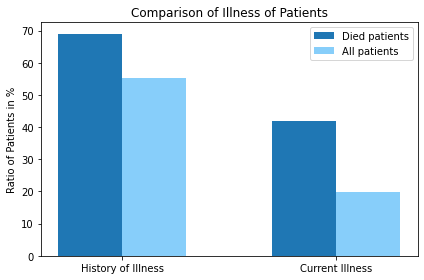

In [54]:
labels = ['History of Illness', 'Current Illness']
died_values = [ratio_history_death, ratio_illness_death]
all_values = [ratio_history_all, ratio_illness_all]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, died_values, width, label='Died patients')
rects2 = ax.bar(x + width/2, all_values, width, label='All patients', color="lightskyblue")

ax.set_ylabel('Ratio of Patients in %')
ax.set_title('Comparison of Illness of Patients')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.savefig("plots/ratio_patients.png")
plt.show()

### Question 3.1: How old were the patients who died after the vaccination?

In [55]:
died["AGE_YRS"].describe()

count    3907.000000
mean       76.555219
std        13.622898
min         1.080000
25%        67.000000
50%        78.000000
75%        88.000000
max       105.000000
Name: AGE_YRS, dtype: float64

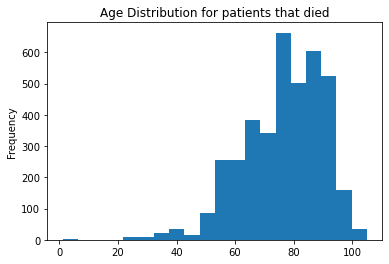

In [56]:
ax = died["AGE_YRS"].plot(kind='hist', bins=20)
ax.set_title("Age Distribution for patients that died")
plt.savefig("plots/age_died.png")
plt.show()

In [57]:
elderly = died[(died["AGE_YRS"] >= 70)]["VAERS_ID"].unique()
print(len(elderly) / persons_died)

0.7056128293241696


**Observation:** 
Higher mean age than our mean age in the complete dataset. 

### Question 4: Can we predict the hospitalization of a patient based on the data?

#### Dataset Cleaning for Prediction Task

In [58]:
def clean_data(df, x_cols, y_col):
    ''' Create dataset and label and create 
    dummy variables for categorical variables and fill numeric columns with mean
    
    INPUT:
    df - pandas dataframe 
    x_cols - list of strings with col names for data
    y_col - string with col name for label
    
    OUTPUT:
    data - new dataframe with columns used as features for prediction
    y - label for dataset
    '''
    
    data = df[x_cols]
    y = df[y_col]

    # check if # rows match
    if data.shape[0] == len(y):
        print("Shapes match")
    else:
        print("Shapes don't match")
    
    # create dummy variables for categorical variables
    cat_vars = data.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each category add dummy variable, drop original column
        data = pd.concat([data.drop(var, axis=1), pd.get_dummies(data[var], prefix=var, 
                                                                 prefix_sep='_', drop_first=False)], axis=1)
        
    # Fill numeric columns with the mean
    num_vars = data.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        data[col].fillna((data[col].mean()), inplace=True)
    
    # standard scaling of data
    scaler = StandardScaler()
    scaled = scaler.fit_transform(data)
    
    return data, y

In [59]:
# Preparation for Data Cleaning
# exclude symptoms with occurence < 20
symp_counts = pt_symp_vax["SYMPTOM"].value_counts()
pt_symp_vax = pt_symp_vax.loc[pt_symp_vax["SYMPTOM"].isin(symp_counts.index[symp_counts >= 20])]

In [60]:
# clean NUMDAYS: take only the ones with day difference < 40
pt_symp_vax = pt_symp_vax[pt_symp_vax["NUMDAYS"] < 40]

In [61]:
# exclude persons with positive Covid-19 test
pt_symp_vax = pt_symp_vax[~pt_symp_vax["VAERS_ID"].isin(cov_pos_id)]

#### Data Preparation

In [62]:
x_cols = ["VAERS_ID", "AGE_YRS", "SEX", "SYMPTOM", "ER_ED_VISIT", "NUMDAYS", "VAX_MANU"]
y_col = "HOSPITAL"
data, y = clean_data(pt_symp_vax, x_cols, y_col)

Shapes match


#### View Possible Correlations between Factors

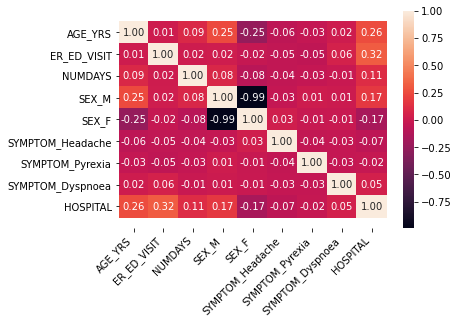

In [63]:
# choose some possibly interesting factors 
data_vis = data[["AGE_YRS", "ER_ED_VISIT", "NUMDAYS","SEX_M", "SEX_F", "SYMPTOM_Headache", 
      "SYMPTOM_Pyrexia", "SYMPTOM_Dyspnoea"]].copy()
data_vis["HOSPITAL"] = pt_symp_vax["HOSPITAL"]
ax = sns.heatmap(data_vis.corr(), annot=True, fmt=".2f");
t = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.savefig("plots/factor_correlation.png", bbox_inches = "tight")
plt.show()

**Observations:**
* slight correlation between hospital and years as well as hospital and ER visit
* slight correlation between hospital and sex
* slight correlation between age and sex
* no real correlations for the single symptoms

#### Data Modeling

In [64]:
def train_test_classifier(X, y, model, model_name):
    ''' Split dataset into train and test, 
    train the model, predict and print the accuracy score
    
    INPUT: 
    X - pandas dataframe dataset to predict from
    y - pandas series labels
    model - classification model (initialized)
    model_name - name of model as string
    '''
    # Split data into train and test dataset
    X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = .35, random_state=42)
    
    # Fit model
    model.fit(X_train, y_train)
    length_y_test = len(y_test) #num in y_test
    length_y_train = len(y_train) #num in y_train
    
    # Calculate score: use of balanced accuracy since only 22 % of the patients were hospitalized -> imbalanced classes
    train_predict = model.predict(X_train)
    train_score = balanced_accuracy_score(y_train, train_predict)
    test_predict = model.predict(X_test)
    test_score = balanced_accuracy_score(y_test, test_predict)
    
    print("Training Accuracy Score for prediction of {} with model {} was {:.2f} on {} values.".format(y.name, model_name, train_score, length_y_train))
    print("Test Accuracy Score for prediction of {} with model {} was {:.2f} on {} values.".format(y.name, model_name, test_score, length_y_test))
    
    return train_score, test_score

In [65]:
# create models
models = []
model_names = []

models.append(LogisticRegression(random_state=0, solver='lbfgs', class_weight='balanced'))
model_names.append("Logistic Regression")
models.append(RandomForestClassifier(max_depth=2, random_state=0, class_weight='balanced'))
model_names.append("Random Forest Classifier")
models.append(GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, 
                                      max_depth=1, random_state=0))
model_names.append("Gradient Boosting Classifier")

In [66]:
results = []
for i in range(len(models)):
    # train models, train_score not needed for now because we see that there is no real overfitting
    _, test_score = train_test_classifier(data, y, models[i], model_names[i])
    results.append(test_score)

Training Accuracy Score for prediction of HOSPITAL with model Logistic Regression was 0.50 on 21910 values.
Test Accuracy Score for prediction of HOSPITAL with model Logistic Regression was 0.50 on 11798 values.
Training Accuracy Score for prediction of HOSPITAL with model Random Forest Classifier was 0.78 on 21910 values.
Test Accuracy Score for prediction of HOSPITAL with model Random Forest Classifier was 0.78 on 11798 values.
Training Accuracy Score for prediction of HOSPITAL with model Gradient Boosting Classifier was 0.78 on 21910 values.
Test Accuracy Score for prediction of HOSPITAL with model Gradient Boosting Classifier was 0.77 on 11798 values.


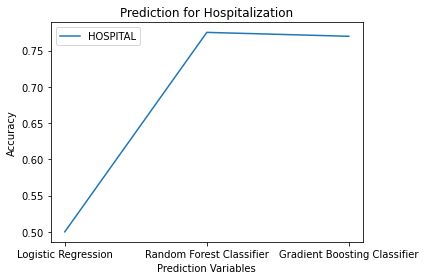

In [67]:
fig, ax = plt.subplots()

plt.plot(model_names, results, label=y.name)

ax.set(xlabel='Prediction Variables', ylabel='Accuracy',
       title='Prediction for Hospitalization')

plt.legend() 
plt.savefig("plots/prediction_results.png")
fig.tight_layout()
plt.show()

**Results:** 
* no optimal prediction results
* could improve through hyperparameter optimization, additional information in the datset (which would have to be cleaned first),  more data